In [928]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [929]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [930]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [931]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [932]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.698e-02 ...  4.989e+03  5.000e+03]
        y: [[ 1.000e+02  1.001e+02 ...  6.308e+01  6.877e+01]
            [ 1.000e+00  1.253e+00 ...  3.343e+01  3.945e+01]
            ...
            [ 1.000e+00  9.988e-01 ... -7.076e-07 -1.458e-07]
            [ 1.000e+00  9.997e-01 ...  6.556e-07  1.346e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4148
     njev: 0
      nlu: 0


In [933]:
time_transient, p_transient, m_transient, Mf_transient, Mb_transient, n_transient = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

[]

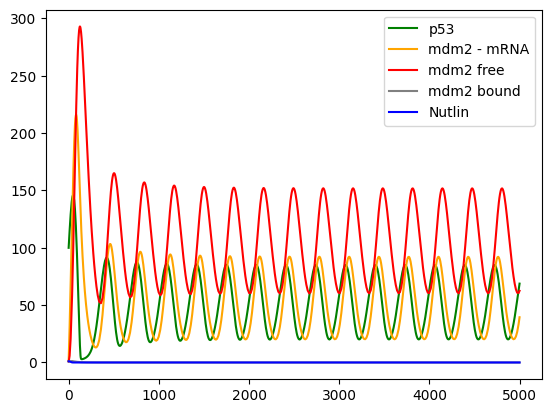

In [935]:
plt.plot(time_transient, p_transient, color="green", label="p53")
plt.plot(time_transient, m_transient, color="orange", label="mdm2 - mRNA")
plt.plot(time_transient, Mf_transient, color="red", label="mdm2 free")
plt.plot(time_transient, Mb_transient, color="gray", label="mdm2 bound")
plt.plot(time_transient, n_transient, color="blue", label="Nutlin")


plt.legend()
plt.plot()

# Peakfinding på transient

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

In [936]:
# Compute stats for p53 transient to find period and amplitude for nutlin simulation
def compute_external_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [937]:
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_external_oscillator(time_transient, p_transient)

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

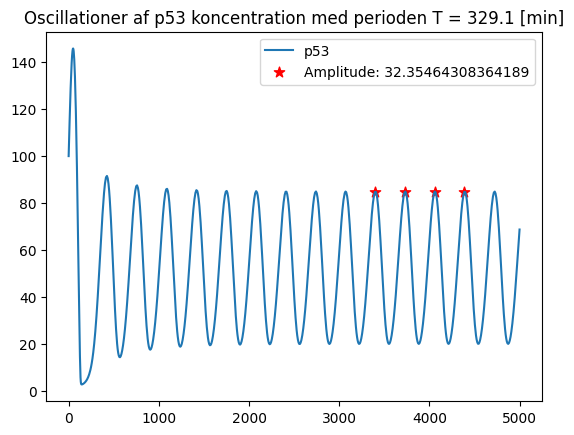

In [938]:
plt.plot(time_transient, p_transient, label="p53")
plt.scatter(time_transient[stable_peaks_int], p_transient[stable_peaks_int], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

# Simulér med nutlin

In [939]:
def sim_onoff_nutlin(oscillationer, T_int, OOmega, p0, m0, Mf0, Mb0, A_ext):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    # TODO: Undersøg max_step i fremtiden
    for i in range(oscillationer):
        if i == 0:
            state = p0, m0, Mf0, Mb0, A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Every period, Nutlin concentration is reset to A_ext
        state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
        t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["p"].extend(p)
        history["m"].extend(m)
        history["Mf"].extend(Mf)
        history["Mb"].extend(Mb)
        history["n"].extend(n)
    
    return history, omega, T_ext

In [1409]:
current_omega = 2.3
coupling_strength = 0.4
Nutlin_A = A_int*coupling_strength

In [1410]:
nutlin_sim1, omega, T_ext_sim1 = sim_onoff_nutlin(200, T_int, current_omega, p_transient[-1], m_transient[-1], Mf_transient[-1], Mb_transient[-1], Nutlin_A)

In [1411]:
t_1, p_1, m_1, Mb_1, Mf_1, n_1 = np.array(nutlin_sim1["t"]), np.array(nutlin_sim1["p"]), np.array(nutlin_sim1["m"]), np.array(nutlin_sim1["Mb"]), np.array(nutlin_sim1["Mf"]), np.array(nutlin_sim1["n"])

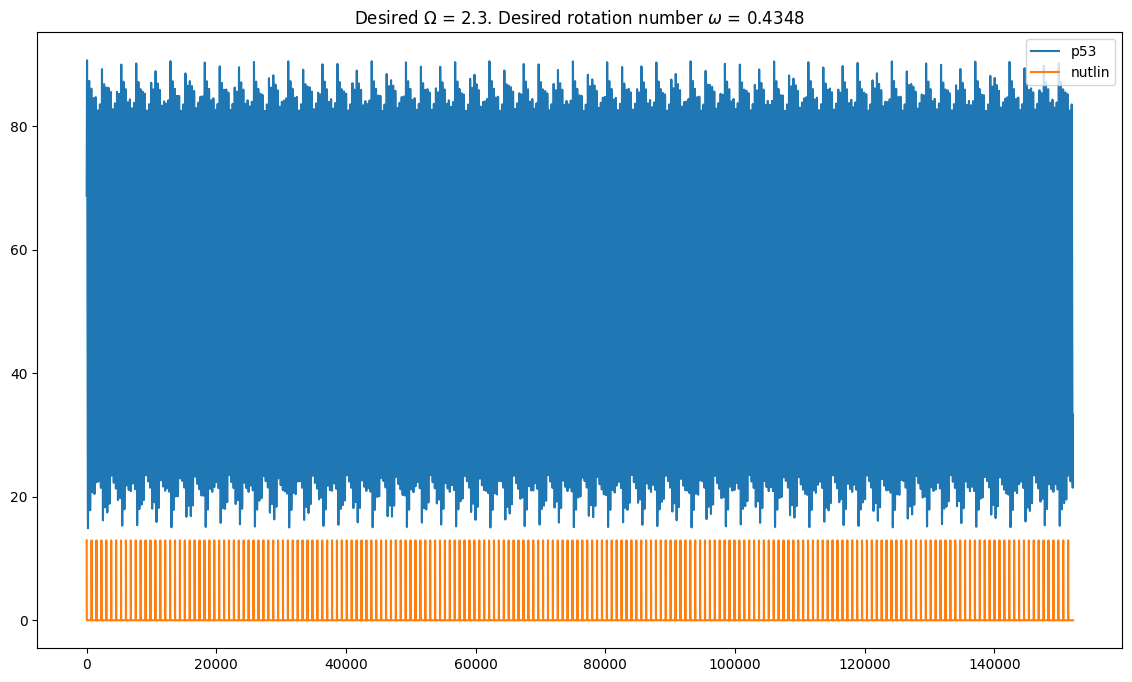

In [1412]:
plt.figure(figsize=(14, 8))

plt.plot(t_1, p_1, label="p53")
plt.plot(t_1, n_1, label="nutlin")
# plt.plot(t_1, m_1, label="mRNA")
# plt.plot(t_1, Mb_1, label="Mb")
# plt.plot(t_1, Mf_1, label="Mf")

plt.title(rf"Desired $\Omega$ = {current_omega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()

# plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.4} [min]")

[]

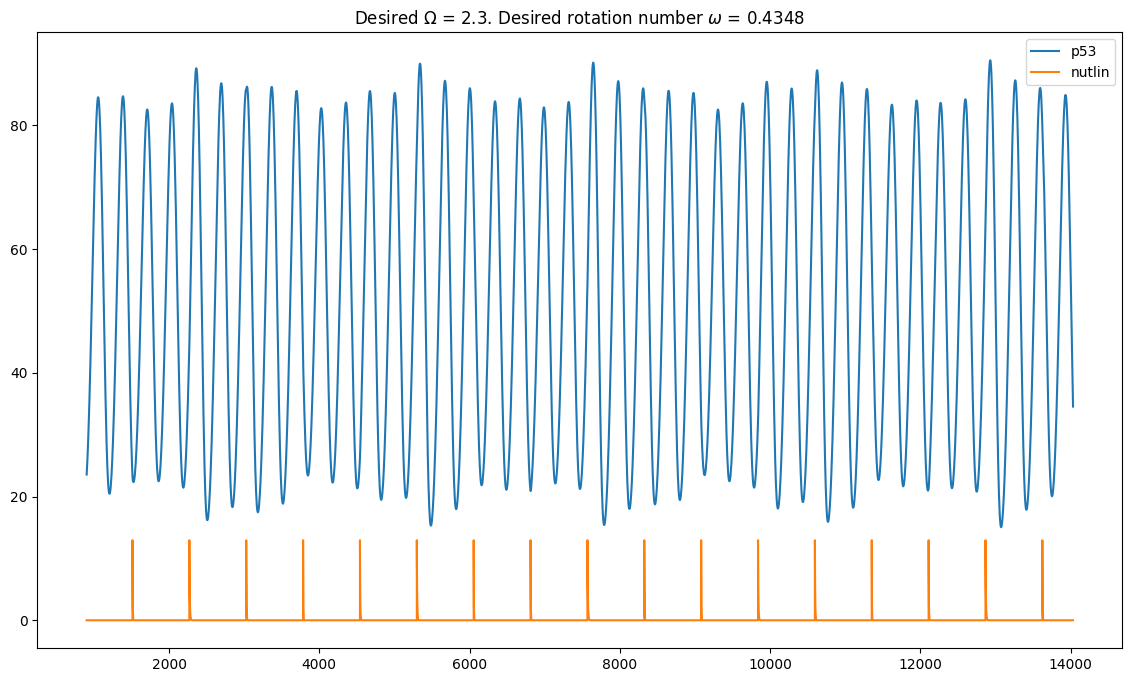

In [1413]:
plt.figure(figsize=(14, 8))

plt.plot(t_1[200:3000], p_1[200:3000], label="p53")
plt.plot(t_1[200:3000], n_1[200:3000], label="nutlin")

# for i in range(len(peaks_nutlin)):
#     plt.scatter(t_1[peaks_nutlin[i]], n_1[peaks_nutlin[i]], c="red", marker='*')

# for i in range(len(troughs_p53)):
#     plt.scatter(t_1[troughs_p53[i]], p_1[troughs_p53[i]], c="black", marker='*')

plt.title(rf"Desired $\Omega$ = {current_omega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()
plt.plot()

In [1414]:
_, _, _, all_p53_peaks_after_adding_nutlin, _ = compute_external_oscillator(np.array(t_1), np.array(p_1))

___

# Relative Tolerance Peak Finding Implementation

In [1415]:
# Running this after starting nutlin
# For finding a candidate for peak height of highest peaks.
def get_peak_height(y):
    y_peaks = find_peaks(y, height=None)[0][-30:]
    reference_height = 0

    for peak in y_peaks:
        if y[peak] > reference_height:
            reference_height = y[peak]
        else:
            continue
        
    return y_peaks, reference_height

In [1416]:
highest_peak_candidates, top_peak_height_after_transient = get_peak_height(p_1)

In [1417]:
# Use "get_peak_height" after running nutlin sim to get a feeling for where the highest peaks are after adding nutlin
def find_highest_peaks_nutlin(y, reference_height, current_OOmega):

    # This is a list of clean rotation numbers, where the rtol should be very low, 
    # because the oscillations are so stable that we can easily distinguish between highest and lowest peak series without getting into problems we think.
    nice_values = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

    rtol = None

    if np.isin(current_OOmega, nice_values):
        rtol = 1e-2
    else:
        rtol = 0.3 + 1/(10*coupling_strength) * 1/(1 + np.exp(coupling_strength)) # Arbritary sigmoid

    height_interval = [reference_height - rtol, reference_height + rtol]

    y_peaks = find_peaks(y, height=height_interval)[0]

    return y_peaks

In [1418]:
top_peaks_after_adding_nutlin = find_highest_peaks_nutlin(p_1, top_peak_height_after_transient, 2)

IndexError: index 2 is out of bounds for axis 0 with size 1

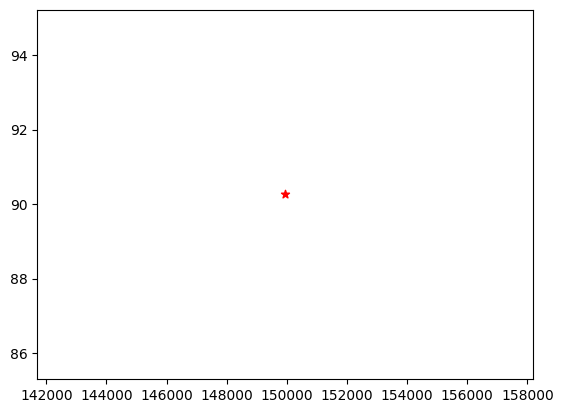

In [1419]:
window_left = 0
window_right = 2

# Kinda cryptic, just windows it without transient
plt.scatter(t_1[top_peaks_after_adding_nutlin[window_left:window_right]], p_1[top_peaks_after_adding_nutlin[window_left:window_right]], marker='*', color="red")
plt.plot(t_1[top_peaks_after_adding_nutlin[window_left]:top_peaks_after_adding_nutlin[window_right]],p_1[top_peaks_after_adding_nutlin[window_left]:top_peaks_after_adding_nutlin[window_right]])

In [1375]:
def show_period_convergence(t, peaks, T_ext):
    approx_big_omega = np.floor(len(all_p53_peaks_after_adding_nutlin)/len(top_peaks_after_adding_nutlin))
    top_period_spacing = np.diff(t[peaks])
    T_int = top_period_spacing / approx_big_omega

    OOmega_array = np.round(T_ext / T_int, 5)
    return OOmega_array

In [1376]:
period_convergence = show_period_convergence(t_1, top_peaks_after_adding_nutlin, T_ext_sim1)

In [1377]:
x_dummy = np.arange(len(period_convergence))

[]

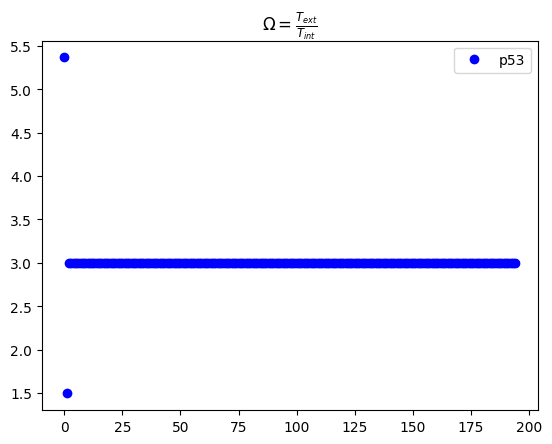

In [1378]:
plt.plot(x_dummy, period_convergence, 'bo', label=r"p53")

plt.legend()

plt.title(r"$\Omega = \frac{T_{ext}}{T_{int}}$")
plt.plot()

___
# Klassifikation af entrainment

In [1379]:
xxs = np.linspace(0.01, 0.99, 101)

In [1380]:
1/xxs * 1/(1 + np.exp(xxs))

array([49.75000208, 25.00253342, 16.64191014, 12.44038767,  9.91265204,
        8.22464877,  7.01754043,  6.11145178,  5.40627127,  4.8418504 ,
        4.37987235,  3.99477087,  3.66883395,  3.38940276,  3.14718957,
        2.93522563,  2.74817994,  2.5819048 ,  2.43312478,  2.29921887,
        2.17806481,  2.06792585,  1.96736701,  1.87519226,  1.79039679,
        1.71213025,  1.63966817,  1.57238948,  1.50975875,  1.45131186,
        1.39664455,  1.34540304,  1.29727643,  1.25199035,  1.20930177,
        1.16899467,  1.13087633,  1.09477434,  1.06053394,  1.02801583,
        0.99709431,  0.96765564,  0.93959665,  0.91282354,  0.88725084,
        0.86280052,  0.83940117,  0.81698734,  0.79549891,  0.77488057,
        0.75508134,  0.73605416,  0.71775553,  0.70014514,  0.68318565,
        0.66684235,  0.65108297,  0.63587747,  0.62119785,  0.60701796,
        0.59331337,  0.58006122,  0.56724011,  0.55482995,  0.54281192,
        0.53116831,  0.51988248,  0.50893876,  0.49832238,  0.48

In [1381]:
steep = 1

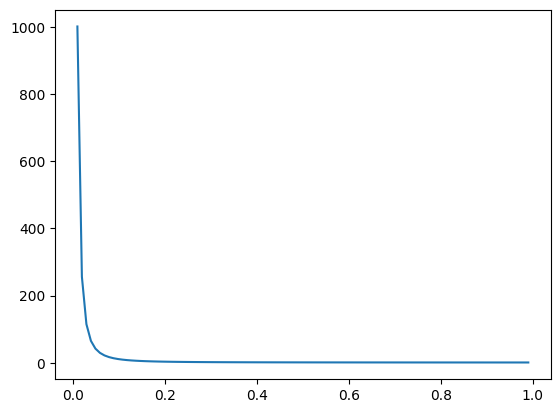

In [1382]:
plt.plot(xxs, 1 + 1/(10*xxs) * 1/((1 +(1 / xxs) - 1)**(-steep)))

In [1383]:
def check_entrainment(t, y, coupling_strength, current_OOmega, T_ext):

    # This is a list of clean rotation numbers, where the rtol should be very low, 
    # because the oscillations are so stable that we can easily distinguish between highest and lowest peak series without getting into problems we think.
    nice_values = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

    rtol = None

    if np.isin(current_OOmega, nice_values):
        rtol = 1e-2
    else:
        rtol = 1 + 1/(10*coupling_strength) * 1/(1 + np.exp(coupling_strength)) # Arbritary sigmoid

    # Running this after starting nutlin
    # For finding a candidate for peak height of highest peaks.
    y_peaks = find_peaks(y, height=None)[0][-10:] # Not going to an Omega larger than 5
    reference_height = 0

    for peak in y_peaks:
        if y[peak] > reference_height:
            reference_height = y[peak]
        else:
            continue

    # get a feeling for where the highest peaks are after adding nutlin
    height_interval = [reference_height - rtol, reference_height + rtol]

    top_peaks_after_adding_nutlin = find_peaks(y, height=height_interval)[0]

    approx_big_omega = np.floor(len(all_p53_peaks_after_adding_nutlin)/len(top_peaks_after_adding_nutlin))
    top_period_spacing = np.diff(t[top_peaks_after_adding_nutlin])
    T_int = top_period_spacing / approx_big_omega

    OOmega_array = np.round(T_ext / T_int, 4)

    identical = OOmega_array[OOmega_array[::-1] == OOmega_array[-1]]
    
    if len(identical) >= 5:
        return True
    else:
        return False

In [1384]:
check_entrainment(t_1, p_1, coupling_strength, 0.6, T_ext_sim1)

True